# 【問題1】クロスバリデーション


- 事前学習期間は検証用データを分割しておき、それに対して指標値を計算することで検証を行った。しかし、分割の仕方により精度は変化する。  
実践的にはクロスバリデーションを行う。
- 具体的には分割を複数回行い、それぞれに対して学習と検証を行う方法。複数回の分割を行う関数はscikit-learnにKFoldとして用意されている。  
今回はクロスバリデーションに cross_val_scoreを使った。

欠損値の穴埋めにはWeek4授業課題に使った自作のkesson関数を使う。かなり重いので今回はkesson関数を使った前処理を施したPandasファイルを読み込むことで関数実行の時間を省略する。

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import KFold, cross_val_score

%matplotlib inline


/anaconda3/envs/DIC/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
testdf = pd.read_csv('application_test.csv')
test_features = testdf.loc[:,['EXT_SOURCE_3','EXT_SOURCE_1','EXT_SOURCE_2','DAYS_BIRTH','DAYS_EMPLOYED','AMT_GOODS_PRICE','AMT_CREDIT']]

# 【問題3】前処理・Feature Engineering・学習

In [3]:
df = pd.read_csv('concat_target_features.csv')

In [4]:
target = df['TARGET'][:, np.newaxis]
features = df.loc[:,['EXT_SOURCE_3','EXT_SOURCE_1','EXT_SOURCE_2','DAYS_BIRTH','DAYS_EMPLOYED','AMT_GOODS_PRICE','AMT_CREDIT']]

In [5]:
num_test = 0.20
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=num_test, random_state=23)

# 【問題2】グリッドサーチ

In [6]:
#2値分類、不均衡データ、その他はデフォルト
lgb_c = lgb.LGBMClassifier(random_state=0,class_weight='balanced',objective='binary')

#学習
lgb_c.fit(X_train,y_train,eval_metric='auc')

#予測(確率で)
target_probabilities = lgb_c.predict_proba(X_test)[:,1]

/anaconda3/envs/DIC/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/envs/DIC/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# 【問題2】指標値

0.7402132735756417


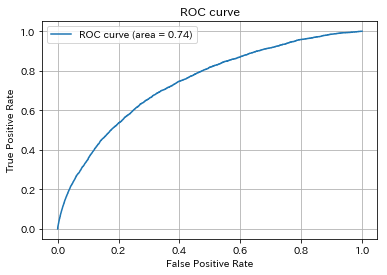

In [7]:
from sklearn import metrics
# FPR, TPR(, しきい値) を算出
fpr, tpr, thresholds = metrics.roc_curve(y_test, target_probabilities)

# ついでにAUCも
auc = metrics.auc(fpr, tpr)
print(auc)
# ROC曲線をプロット
plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc)
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

In [8]:
target_probabilities

array([0.40088738, 0.24219531, 0.3491262 , ..., 0.47156736, 0.3417494 ,
       0.49366652])

In [9]:
cvs = cross_val_score(lgb_c, X_test, y_test, cv=3, scoring='roc_auc')

/anaconda3/envs/DIC/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/envs/DIC/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/envs/DIC/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/envs/DIC/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change t

In [10]:
print(cvs)

[0.7268413  0.71764374 0.72126981]


In [11]:
testdf = pd.read_csv('application_test.csv')

In [12]:
testdf = pd.get_dummies(testdf)

In [13]:
testdf = testdf.fillna(0)

In [14]:
test_features = testdf.loc[:,['EXT_SOURCE_3','EXT_SOURCE_1','EXT_SOURCE_2','DAYS_BIRTH','DAYS_EMPLOYED','AMT_GOODS_PRICE','AMT_CREDIT']]

In [15]:
test_target_proba = lgb_c.predict_proba(test_features)[:,1]
test_target_proba

array([0.24355777, 0.51947292, 0.51190811, ..., 0.35347387, 0.52660851,
       0.84870032])

In [18]:
data = {"SK_ID_CURR":testdf['SK_ID_CURR'].values,"TARGET":test_target_proba}
df = pd.DataFrame(data).set_index("SK_ID_CURR")
df.to_csv('./target2_features.csv')

In [ ]:
import pickle
filename = 'lgb_model.sav'
pickle.dump(best_model, open(filename, 'wb'))

# 【問題3】Kernelからの調査

https://www.kaggle.com/jpmiller/patterns-of-missing-data

上記のカーネルでデンドログラムを使って似た特徴量をクラスタリングしていた。これなら重要度の高い特徴量をランダムフォレスト で  
見つけてそこから似たような特徴量を見つけることができる。

また  
Statistical Significance
To be thorough, I looked at statistical significance of the difference in default rates between groups.  
I used a G-test which is similar to Pearson's chi-squared test. Either one should work in this case, but I generally prefer the G-test.

とある様にscipyのライブラリを使っていることも新しかった。統計を見る為には統計のパッケージを使うのは当たり前といえば当たり前だがkaggle初心者には盲点

# 【問題4】高い汎化性能のモデル

今回はLGBMClassifierを使って簡単にkaggleしてみたがグリッドサーチに比べて異常に早い。これならストレス無しで組み合わせを試せるのでこれから様々な手法を試してみようと思う。  
またscipyで統計を勉強して多角的に分析しようと思う。